In [2]:
#Import Packages
import pandas as pd 
import numpy as np 
import seaborn as sns
from fuzzywuzzy import fuzz, process
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import re
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as seabornInstance 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

C:\Users\micha\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
#Bring in Coaches Data
datapath = 'C:\\Users\\micha\\Documents\\IST 718\\Coaches8.csv'
Coaches = pd.read_csv(datapath, sep=',')
Coaches.shape

(130, 9)

In [4]:
#Bring in Stadiums Data
datapath1 = 'C:\\Users\\micha\\Documents\\IST 718\\Stadiums.csv'
Stadiums = pd.read_csv(datapath1, sep=',' )
Stadiums.shape

(130, 6)

In [5]:
#Bring in CollegeRecords Data
datapath3 = 'C:\\Users\\micha\\Documents\\IST 718\\CollegeRecords.csv'
CollegeRecords = pd.read_csv(datapath3, sep=',')
CollegeRecords.shape

(130, 9)

In [6]:
#Bring in GraduationRates Data
datapath4 = 'C:\\Users\\micha\\Documents\\IST 718\\GraduationRates.csv'
GraduationRates = pd.read_csv(datapath4, sep=',')
GraduationRates.shape

(249, 11)

In [7]:
print(Coaches.info())
print(Coaches.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   School        130 non-null    object
 1   Conference    130 non-null    object
 2   Coach         130 non-null    object
 3   SchoolPay     130 non-null    object
 4   TotalPay      130 non-null    object
 5   Bonus         130 non-null    object
 6   BonusPaid     130 non-null    object
 7   AssistantPay  130 non-null    object
 8   Buyout        130 non-null    object
dtypes: object(9)
memory usage: 9.3+ KB
None
(130, 9)


In [8]:
#Get a general view of the data we are dealing with 
Coaches[Coaches['Conference']=='SEC']

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000"
7,Arkansas,SEC,Chad Morris,"$3,500,000","$3,500,000","$1,000,000",--,$0,"$12,500,000"
10,Auburn,SEC,Gus Malzahn,"$6,700,000","$6,705,656","$1,400,000","$375,000",$0,"$32,143,750"
31,Florida,SEC,Dan Mullen,"$6,070,000","$6,070,000","$925,000",--,$0,"$12,000,000"
36,Georgia,SEC,Kirby Smart,"$6,603,600","$6,603,600","$1,150,000","$1,350,000",$0,"$27,917,500"
49,Kentucky,SEC,Mark Stoops,"$4,000,000","$4,013,600","$3,100,000","$300,000",$0,"$15,625,000"
55,LSU,SEC,Ed Orgeron,"$3,500,000","$3,500,000","$1,575,000","$100,000",$0,"$5,291,667"
66,Mississippi,SEC,Matt Luke,"$3,000,000","$3,000,000","$1,550,000",--,$0,$0
67,Mississippi State,SEC,Joe Moorhead,"$2,600,000","$2,600,000","$1,350,000",--,$0,$0
68,Missouri,SEC,Barry Odom,"$2,350,000","$2,350,000","$1,025,000","$375,000",$0,"$1,912,500"


In [9]:
#Select all columns that need to be numeric. BonusPaid, AssistantPay and Buyout are not included because they will be removed later as they are useless in this analysis. 
NumericCols = ['SchoolPay', 'TotalPay', 'Bonus']

#Convert Numeric Columns into Floats. 
for d in NumericCols:
    Coaches[d] = Coaches[d].replace('[$,]', '', regex=True)
    Coaches[d] = Coaches[d].replace('[--]', '0', regex=True)
    Coaches[d] = Coaches[d].astype(float)
     
Coaches.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,--,$0,--
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,"$50,000",$0,"$688,500"
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,"$500,000",$0,"$33,600,000"
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,"$165,471",$0,"$3,847,500"
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,"$145,000",$0,"$2,160,417"


In [10]:
#After further thinking about what data is necessary I've determined that AssistantPay, BonusPaid, and Buyout are not needed either so they will be removed. 
#AssistantPay contains no data so get rid of it
Coaches=Coaches.drop(columns=['AssistantPay'])
print(Coaches)

                    School Conference              Coach  SchoolPay  \
0                Air Force   Mt. West       Troy Calhoun   885000.0   
1                    Akron        MAC       Terry Bowden   411000.0   
2                  Alabama        SEC         Nick Saban  8307000.0   
3    Alabama at Birmingham      C-USA         Bill Clark   900000.0   
4        Appalachian State   Sun Belt  Scott Satterfield   712500.0   
..                     ...        ...                ...        ...   
125          West Virginia     Big 12     Dana Holgorsen  3605000.0   
126       Western Kentucky      C-USA   Mike Sanford Jr.   800000.0   
127       Western Michigan        MAC         Tim Lester   800000.0   
128              Wisconsin    Big Ten        Paul Chryst  3750000.0   
129                Wyoming   Mt. West         Craig Bohl  1412000.0   

      TotalPay      Bonus  BonusPaid        Buyout  
0     885000.0   247000.0         --            --  
1     412500.0   225000.0   $50,000      

In [11]:
#Drop Bonus Paid since we do not know how and at what time bonuses are to be paid based on different contracts for each coach. 
#The 'Bonus' field can be useful since this is the number that is stated on the contract for each coach. 
Coaches=Coaches.drop(columns=['BonusPaid'])
print(Coaches)

                    School Conference              Coach  SchoolPay  \
0                Air Force   Mt. West       Troy Calhoun   885000.0   
1                    Akron        MAC       Terry Bowden   411000.0   
2                  Alabama        SEC         Nick Saban  8307000.0   
3    Alabama at Birmingham      C-USA         Bill Clark   900000.0   
4        Appalachian State   Sun Belt  Scott Satterfield   712500.0   
..                     ...        ...                ...        ...   
125          West Virginia     Big 12     Dana Holgorsen  3605000.0   
126       Western Kentucky      C-USA   Mike Sanford Jr.   800000.0   
127       Western Michigan        MAC         Tim Lester   800000.0   
128              Wisconsin    Big Ten        Paul Chryst  3750000.0   
129                Wyoming   Mt. West         Craig Bohl  1412000.0   

      TotalPay      Bonus        Buyout  
0     885000.0   247000.0            --  
1     412500.0   225000.0     $688,500   
2    8307000.0  11000

In [12]:
#Buyout provides no substantial benefit to this analysis. 
Coaches=Coaches.drop(columns=['Buyout'])
print(Coaches)

                    School Conference              Coach  SchoolPay  \
0                Air Force   Mt. West       Troy Calhoun   885000.0   
1                    Akron        MAC       Terry Bowden   411000.0   
2                  Alabama        SEC         Nick Saban  8307000.0   
3    Alabama at Birmingham      C-USA         Bill Clark   900000.0   
4        Appalachian State   Sun Belt  Scott Satterfield   712500.0   
..                     ...        ...                ...        ...   
125          West Virginia     Big 12     Dana Holgorsen  3605000.0   
126       Western Kentucky      C-USA   Mike Sanford Jr.   800000.0   
127       Western Michigan        MAC         Tim Lester   800000.0   
128              Wisconsin    Big Ten        Paul Chryst  3750000.0   
129                Wyoming   Mt. West         Craig Bohl  1412000.0   

      TotalPay      Bonus  
0     885000.0   247000.0  
1     412500.0   225000.0  
2    8307000.0  1100000.0  
3     900000.0   950000.0  
4     7

In [13]:
#Clean Stadiums Dataset
print(Stadiums.info())

Stadiums['Capacity'] = Stadiums['Capacity'].replace(',', '', regex=True).astype(float)
Stadiums.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Stadium     130 non-null    object 
 1   College     130 non-null    object 
 2   Conference  130 non-null    object 
 3   Capacity    130 non-null    int64  
 4   Opened      130 non-null    int64  
 5   Unnamed: 5  0 non-null      float64
dtypes: float64(1), int64(2), object(3)
memory usage: 6.2+ KB
None


,Stadium,College,Conference,Capacity,Opened,Unnamed: 5
0,Bright House Networks Stadium,Central Florida,AAC,45323.0,2007,NaN
1,Nippert Stadium,Cincinnati,AAC,40000.0,1916,NaN
2,Dowdy Ficklen Stadium,East Carolina,AAC,50000.0,1963,NaN
3,TDECU Stadium,Houston,AAC,40000.0,2014,NaN
4,Liberty Bowl,Memphis,AAC,62380.0,1965,NaN


In [14]:
#Compare fields between the two datasets.
print(len(Coaches.Conference.unique()), Coaches.Conference.unique())
print(len(CollegeRecords.Conference.unique()), CollegeRecords.Conference.unique())

11 ['Mt. West' 'MAC' 'SEC' 'C-USA' 'Sun Belt' 'Pac-12' 'Ind.' 'Big 12' 'ACC'
 'AAC' 'Big Ten']
11 ['Atlantic Coast Conference' 'American Athletic Conference' 'Big 12'
 'Big 10' 'Conference USA' 'Independents' 'Mid-American Conference'
 'Mountain West' 'Pac-12' 'Southeastern Conference' 'Sun Belt']


In [15]:
#Make sure the naming conventions for the datasets match
OriginalName = ['Atlantic Coast Conference', 'American Athletic Conference', 'Big 12', 'Big 10', 'Conference USA', 'Independents', 'Mid-American Conference','Mountain West', 'Pac-12', 
                'Southeastern Conference', 'Sun Belt']
NewName = ['ACC', 'AAC', 'Big 12', 'Big Ten', 'C-USA', 'Ind.', 'MAC', 'Mt. West', 'Pac-12', 'SEC', 'Sun Belt']
 
CollegeRecords['Conference'] = CollegeRecords['Conference'].replace(OriginalName, NewName, regex=False)
CollegeRecords.head()

,Conference,School,HomeW,HomeL,ConfW,ConfL,PF,PA,Unnamed: 8
0,ACC,Clemson,8,0,15,0,664,197,NaN
1,ACC,Syracuse,6,2,10,3,523,351,NaN
2,ACC,North Carolina State,5,3,9,4,440,324,NaN
3,ACC,Boston College,4,4,7,5,384,308,NaN
4,ACC,Wake Forest,3,5,7,6,427,433,NaN


In [16]:
#Clean Graduation Dataset 
print(len(GraduationRates.Conference.unique()), print(GraduationRates.Conference.unique()))

['Southland Conference' 'Mid-American Conference'
 'Southwestern Athletic Conf.' 'Southeastern Conference' 'Conference USA'
 'Colonial Athletic Association' 'Sun Belt Conference' 'Pac-12 Conference'
 'Ohio Valley Conference' 'Big South Conference' 'Big 12 Conference'
 'Mid-Eastern Athletic Conf.' 'Mountain West Conference'
 'Atlantic Coast Conference' 'Independent' 'The Ivy League'
 'Northeast Conference' 'Patriot League' 'Pioneer Football League'
 'Big Sky Conference' 'American Athletic Conference' 'Southern Conference'
 'Missouri Valley Football Conference' 'Big Ten Conference']
24 None


In [17]:
#Make sure the naming conventions for the datasets match
OriginalGraduation = ['Southland Conference', 'Mid-American Conference', 'Southwestern Athletic Conf.', 'Southeastern Conference', 'Conference USA', 'Colonial Athletic Association', 'Sun Belt Conference', 
            'Pac-12 Conference', 'Ohio Valley Conference', 'Big South Conference', 'Big 12 Conference', 'Mid-Eastern Athletic Conf.', 'Mountain West Conference', 'Atlantic Coast Conference', 
            'Independent',  'The Ivy League', 'Northeast Conference', 'Patriot League', 'Pioneer Football League', 'Big Sky Conference', 'American Athletic Conference', 'Southern Conference', 
            'Missouri Valley Football Conference', 'Big Ten Conference']

NewGraduation = ['SLC', 'MAC', 'SWAC', 'SEC', 'C-USA', 'CAA', 'Sun Belt', 'Pac-12', 'OVC', 'Big South', 'Big 12', 'MEAC', 'Mountain West', 'ACC', 'Independent', 'Ivy', 'NEC', 'Patriot', 'PFL', 'Big Sky', 'AAC', 'Southern', 'MVFC', 
           'Big Ten']

GraduationRates['Conference'] = GraduationRates['Conference'].replace(OriginalGraduation, NewGraduation, regex=False)

In [18]:
#GraduationRates = GraduationRates.iloc[:, 0:8]
GraduationRates.head(50)

,Cohort Year,Year,School,Conference,Sport,State,GSR,FGR,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,2011,2017-2018,Abilene Christian University,SLC,Football,TX,61,41.0,NaN,NaN,NaN
1,2011,2017-2018,University of Akron,MAC,Football,OH,72,61.0,NaN,NaN,NaN
2,2011,2017-2018,Alabama A&M University,SWAC,Football,AL,62,47.0,NaN,NaN,NaN
3,2011,2017-2018,Alabama State University,SWAC,Football,AL,58,42.0,NaN,NaN,NaN
4,2011,2017-2018,University of Alabama,SEC,Football,AL,84,63.0,NaN,NaN,NaN
5,2011,2017-2018,University of Alabama at Birmingham,C-USA,Football,AL,71,58.0,NaN,NaN,NaN
6,2011,2017-2018,University at Albany,CAA,Football,NY,90,67.0,NaN,NaN,NaN
7,2011,2017-2018,Alcorn State University,SWAC,Football,MS,67,44.0,NaN,NaN,NaN
8,2011,2017-2018,Appalachian State University,Sun Belt,Football,NC,71,67.0,NaN,NaN,NaN
9,2011,2017-2018,Arizona State University,Pac-12,Football,AZ,73,61.0,NaN,NaN,NaN


In [64]:
CollegeRecords.head()

,Conference,School,HomeW,HomeL,ConfW,ConfL,PF,PA,Unnamed: 8,FuzzySchool
0,ACC,Clemson,8,0,15,0,664,197,NaN,Clemson
1,ACC,Syracuse,6,2,10,3,523,351,NaN,Syracuse
2,ACC,North Carolina State,5,3,9,4,440,324,NaN,North Carolina State
3,ACC,Boston College,4,4,7,5,384,308,NaN,Boston College
4,ACC,Wake Forest,3,5,7,6,427,433,NaN,Wake Forest


In [19]:
#Further cleaning to a few more College Names 
CollegeRecords['School'] = CollegeRecords['School'].replace('UCF', 'Central Florida', regex=False)
CollegeRecords['School'] = CollegeRecords['School'].replace('Miami (FL)', 'Miami (Fla.)', regex=False)
CollegeRecords['School'] = CollegeRecords['School'].replace(['UTSA', 'UTEP', 'Southern Miss'], ['Texas-San Antonio', 'Texas-El Paso', 'Southern Mississippi'], regex=False)

In [20]:
#Records & Coaches
CollegeRecords['FuzzySchool'] = CollegeRecords.School.apply(lambda x: [process.extract(x, Coaches.School, limit=1)][0][0][0])
Coaches['FuzzySchool'] = Coaches.School.apply(lambda x: [process.extract(x, CollegeRecords.School, limit=1)][0][0][0])

#Select columns to join coaches and records. 
left_on = ['Conference', 'FuzzySchool']
right_on = ['Conference', 'FuzzySchool']

#Bring the two datasets together
CoachRecordDF = pd.merge(Coaches, CollegeRecords, how='left', left_on=left_on, right_on=right_on)
CoachRecordDF[CoachRecordDF.HomeW.isnull()]

,School_x,Conference,Coach,SchoolPay,TotalPay,Bonus,FuzzySchool,School_y,HomeW,HomeL,ConfW,ConfL,PF,PA,Unnamed: 8


In [21]:
#Remove columns that are meaningless
CoachRecordDF.drop(['FuzzySchool', 'School_y'], axis=1, inplace=True)
CoachRecordDF.rename(columns={'School_x':'School'}, inplace=True)

In [24]:
#Further cleaning of team names
OldSchool = ['Connecticut', 'Georgia Tech', 'Miami (Fla.)', 'Virginia', 'Virginia Tech', 'Kansas', 'Kansas State', 'Texas', 
            'Illinois', 'Indiana', 'Iowa', 'Michigan', 'Northwestern', 'Penn State', 'Rutgers', 'Texas-San Antonio', 
           'Fresno State', 'New Mexico', 'California', 'Colorado', 'UCLA', 'Utah', 'Washington', 'Alabama', 'Arkansas', 'Florida', 
            'Georgia', 'Kentucky', 'LSU', 'South Carolina', 'Tennessee', 'Louisiana-Monroe']
 
NewSchool = ['University of Connecticut', 'Georgia Institute of Technology', 'University of Miami (Florida)', 'University of Virginia', 
            'Virginia Polytechnic Institute and State University', 'University of Kansas', 'Kansas State University', 
            'University of Texas at Austin', 'University of Illinois Urbana-Champaign', 'Indiana University, Bloomington', 
            'University of Iowa', 'University of Michigan', 'Northwestern University', 'Pennsylvania State University', 
            'Rutgers, The State University of New Jersey, New Brunswick', 'University of Texas at San Antonio', 
            'California State University, Fresno', 'University of New Mexico', 'University of California, Berkeley', 
            'University of Colorado, Boulder', 'University of California, Los Angeles', 'University of Utah', 'University of Washington', 
            'University of Alabama', 'University of Arkansas, Fayetteville', 'University of Florida', 'University of Georgia', 
            'University of Kentucky', 'Louisiana State University', 'University of South Carolina, Columbia', 
            'University of Tennessee, Knoxville', 'University of Louisiana at Monroe']


CoachRecordDF['School'] = CoachRecordDF['School'].replace(OldSchool, NewSchool, regex=False)

In [25]:
#Coach Record & Graduation Rates
CoachRecordDF['FuzzySchool'] = CoachRecordDF.School.apply(lambda x: [process.extract(x, GraduationRates.School, limit=1)][0][0][0])

left_on = ['Conference', 'FuzzySchool']
right_on = ['Conference', 'School']

CoachRecordDF_gr = pd.merge(CoachRecordDF, GraduationRates, how='left', left_on=left_on, right_on=right_on)
CoachRecordDF_gr.head()

,School_x,Conference,Coach,SchoolPay,TotalPay,Bonus,HomeW,HomeL,ConfW,ConfL,...,Cohort Year,Year,School_y,Sport,State,GSR,FGR,Unnamed: 8_y,Unnamed: 9,Unnamed: 10
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,3,5,5,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,2,6,4,8,...,2011.0,2017-2018,University of Akron,Football,OH,72.0,61.0,NaN,NaN,NaN
2,University of Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,8,0,14,1,...,2011.0,2017-2018,University of Alabama,Football,AL,84.0,63.0,NaN,NaN,NaN
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,7,1,11,3,...,2011.0,2017-2018,University of Alabama at Birmingham,Football,AL,71.0,58.0,NaN,NaN,NaN
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,7,1,11,2,...,2011.0,2017-2018,Appalachian State University,Football,NC,71.0,67.0,NaN,NaN,NaN


In [26]:
#Drop duplicated columns & Rename School_x column
CoachRecordDF_gr.drop(['FuzzySchool', 'School_y'], axis=1, inplace=True)
CoachRecordDF_gr.rename(columns={'School_x':'School'}, inplace=True)

In [27]:
#Coach Record & Stadium
CoachRecordDF_gr['FuzzySchool'] = CoachRecordDF_gr.School.apply(lambda x: [process.extract(x, Stadiums.College, limit=1)][0][0][0])

left_on = ['Conference', 'FuzzySchool']
right_on = ['Conference', 'College']

Finaldf = pd.merge(CoachRecordDF_gr, Stadiums, how='left', left_on=left_on, right_on=right_on)
Finaldf.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,HomeW,HomeL,ConfW,ConfL,...,FGR,Unnamed: 8_y,Unnamed: 9,Unnamed: 10,FuzzySchool,Stadium,College,Capacity,Opened,Unnamed: 5
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,3,5,5,7,...,NaN,NaN,NaN,NaN,Air Force,Falcon Stadium,Air Force,52237.0,1962.0,NaN
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,2,6,4,8,...,61.0,NaN,NaN,NaN,Akron,InfoCision Stadium,Akron,30000.0,2009.0,NaN
2,University of Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,8,0,14,1,...,63.0,NaN,NaN,NaN,University of Alabama,Bryant Denny Stadium,University of Alabama,101821.0,1929.0,NaN
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,7,1,11,3,...,58.0,NaN,NaN,NaN,University of Texas at San Antonio,Alamodome,University of Texas at San Antonio,65000.0,1993.0,NaN
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,7,1,11,2,...,67.0,NaN,NaN,NaN,Appalachain State,Kidd Brewer Stadium,Appalachain State,24150.0,1962.0,NaN


In [28]:
Finaldf.isnull().sum()

School            0
Conference        0
Coach             0
SchoolPay         0
TotalPay          0
Bonus             0
HomeW             0
HomeL             0
ConfW             0
ConfL             0
PF                0
PA                0
Unnamed: 8_x    131
Cohort Year      18
Year             18
Sport            18
State            18
GSR              18
FGR              19
Unnamed: 8_y    131
Unnamed: 9      131
Unnamed: 10     131
FuzzySchool       0
Stadium           1
College           1
Capacity          1
Opened            1
Unnamed: 5      131
dtype: int64

In [29]:
#A few name changes to provide more clarity
Finaldf.rename(columns={'SchoolPay':'Salary', 'ConfW':'ConfWins','ConfL':'ConfLosses','PF':'PointsFor','PA':'PointsAgainst','HomeW':'HomeWins','HomeL':'HomeLosses',
                        'GSR':'GradSuccessRate','FSR':'FedGradRate'}, inplace=True)
print(Finaldf)

                    School Conference              Coach     Salary  \
0                Air Force   Mt. West       Troy Calhoun   885000.0   
1                    Akron        MAC       Terry Bowden   411000.0   
2    University of Alabama        SEC         Nick Saban  8307000.0   
3    Alabama at Birmingham      C-USA         Bill Clark   900000.0   
4        Appalachian State   Sun Belt  Scott Satterfield   712500.0   
..                     ...        ...                ...        ...   
126          West Virginia     Big 12     Dana Holgorsen  3605000.0   
127       Western Kentucky      C-USA   Mike Sanford Jr.   800000.0   
128       Western Michigan        MAC         Tim Lester   800000.0   
129              Wisconsin    Big Ten        Paul Chryst  3750000.0   
130                Wyoming   Mt. West         Craig Bohl  1412000.0   

      TotalPay      Bonus  HomeWins  HomeLosses  ConfWins  ConfLosses  ...  \
0     885000.0   247000.0         3           5         5           7

In [30]:
#Drop the Sport, FuzzySchool, College  columns as they provide no benefit.
Finaldf.drop(['Sport', 'FuzzySchool', 'College'], axis=1, inplace=True)

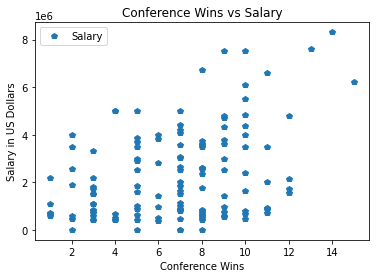

<Figure size 360x504 with 0 Axes>

In [31]:
#Check the link between Conference Wins and Salary
Finaldf.plot(x='ConfWins', y='Salary', style='p') 
plt.title('Conference Wins vs Salary') 
plt.xlabel('Conference Wins') 
plt.ylabel('Salary in US Dollars')
plt.figure(figsize=(5,7))
plt.show()

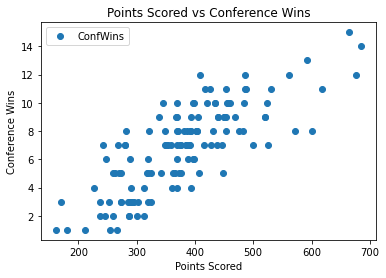

<Figure size 360x504 with 0 Axes>

In [32]:
#Check the link between Points For and Conference Wins
Finaldf.plot(x='PointsFor', y='ConfWins', style='o') 
plt.title('Points Scored vs Conference Wins') 
plt.xlabel('Points Scored') 
plt.ylabel('Conference Wins')
plt.figure(figsize=(5,7))
plt.show()

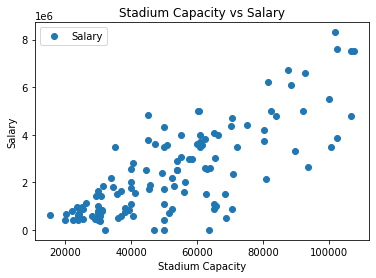

<Figure size 360x504 with 0 Axes>

In [33]:
#Check the link between Points For and Conference Wins
Finaldf.plot(x='Capacity', y='Salary', style='o') 
plt.title('Stadium Capacity vs Salary') 
plt.xlabel('Stadium Capacity') 
plt.ylabel('Salary')
plt.figure(figsize=(5,7))
plt.show()

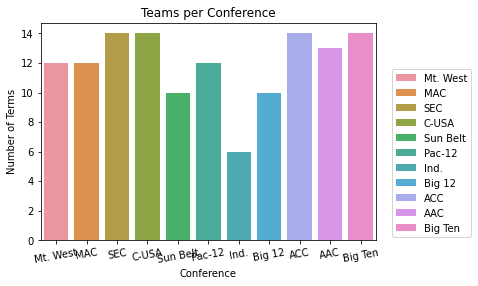

In [34]:
#Take a look at Conference breakdown  
sns.countplot(x='Conference', data=Finaldf, hue='Conference', dodge=False)
_ = plt.xlabel('Conference')
_ = plt.ylabel('Number of Terms')
_ = plt.title('Teams per Conference')
_ = plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.4])
_ = plt.xticks(rotation=10)
plt.show()

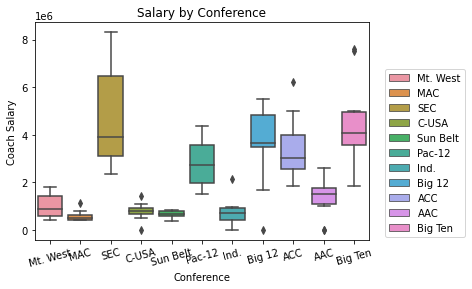

In [35]:
#Box Plot to visualize how Salary and Conference are dispersed. 
sns.boxplot(x='Conference', y='Salary', data=Finaldf, hue='Conference', dodge=False)
_ = plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.4])
_ = plt.xlabel('Conference')
_ = plt.ylabel('Coach Salary')
_ = plt.title('Salary by Conference')
_ = plt.xticks(rotation=15)
plt.show()

In [65]:
#Regression Model 1
ModelDF1 = Finaldf.copy()
ModelDF1 = ModelDF1[ModelDF1.Salary != 0]
Model1=str('Salary ~ Conference + ConfWins + ConfLosses + Capacity  +  PointsFor + PointsAgainst + Bonus')
FitMod1=smf.ols(Model1, data=Finaldf).fit()
print(FitMod1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     27.58
Date:                Sun, 14 Feb 2021   Prob (F-statistic):           1.16e-31
Time:                        13:44:15   Log-Likelihood:                -1959.5
No. Observations:                 130   AIC:                             3953.
Df Residuals:                     113   BIC:                             4002.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -2.5

In [68]:
#Regression Model 1
ModelDF1 = Finaldf.copy()
ModelDF1 = ModelDF1[ModelDF1.Salary != 0]
Model1=str('Salary ~ Conference + ConfWins + Capacity  +  PointsFor')
FitMod1=smf.ols(Model1, data=Finaldf).fit()
print(FitMod1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     34.68
Date:                Sun, 14 Feb 2021   Prob (F-statistic):           7.43e-34
Time:                        13:48:02   Log-Likelihood:                -1959.8
No. Observations:                 130   AIC:                             3948.
Df Residuals:                     116   BIC:                             3988.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.28

In [58]:
#Regression Model 2
ModelDF2 = Finaldf.copy()
ModelDF2 = ModelDF1[ModelDF2.Salary != 0]
Model2=str('Salary ~ Conference')
FitMod2=smf.ols(Model2, data=Finaldf).fit()
print(FitMod2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     23.72
Date:                Sat, 13 Feb 2021   Prob (F-statistic):           4.78e-24
Time:                        15:25:56   Log-Likelihood:                -2007.6
No. Observations:                 131   AIC:                             4037.
Df Residuals:                     120   BIC:                             4069.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.39

<ipython-input-58-44dd0248aef6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ModelDF2 = ModelDF1[ModelDF2.Salary != 0]


In [59]:
#Further Linear regression model analysis using SkLearn
from sklearn.linear_model import LinearRegression
x = Finaldf[['ConfWins','ConfLosses','PointsFor','PointsAgainst','Bonus']]
y = Finaldf['Salary']
SalaryMod = LinearRegression()
SalaryMod.fit(x, y)

LinearRegression()

In [60]:
#Multiple regression model with using Train and Test Datasets
from sklearn.model_selection import train_test_split 
X = Finaldf[['ConfWins','ConfLosses','PointsFor','PointsAgainst','Bonus']]
Y = Finaldf['Salary']
XTrain, XTest, YTrain, YTest = train_test_split(X,Y,test_size=0.2, random_state=10)

#Train the model using 75% of Finaldf data
from sklearn.linear_model import LinearRegression
SalaryMod = LinearRegression()
SalaryMod.fit(XTrain, YTrain)
PredictedSalary = SalaryMod.predict(XTest)

In [61]:
#Coefficients of SalaryModel
print('Coefficients: \n', SalaryMod.coef_)

Coefficients: 
 [4.13707125e+05 3.37673652e+05 1.75225047e+03 4.08994810e+02
 9.53600213e-01]


In [62]:
#R squared of SalaryModel
from sklearn.metrics import r2_score
print('R squared: ',
     r2_score(YTest,PredictedSalary))

R squared:  0.3371593262763447


<function matplotlib.pyplot.show(*args, **kw)>

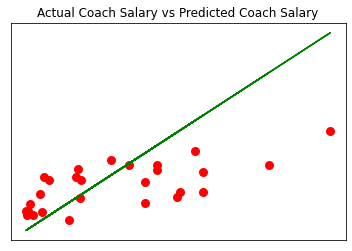

<Figure size 432x576 with 0 Axes>

In [63]:
#Plot Salary results
plt.plot(YTest,YTest, color='Green')
plt.scatter(YTest,PredictedSalary, color='Red',linewidth=3)

plt.title('Actual Coach Salary vs Predicted Coach Salary') 
plt.xticks(())
plt.yticks(())
plt.figure(figsize=(6,8))
plt.show